# Practical session n°2

In Part I:
- Training a CNN on MNIST. Comparison with a multi-layer perceptron.
- Initialization methods, regularization methods.

In Part II:

- Learning on a graphics card.
- Improving gradient descent: SGD with momentum and progressive learning rate decay (scheduler).
- Transfer learning: fine-tuning and freezing.

Duration: 2 h

**Part I**


Now that we have covered the basic building blocks, we will train a Convolutional Neural Network (CNN) on a slightly more challenging problem than separation of points in a 2D space: handwritten digit recognition.

The dataset is named MNIST. It is located in the shared folder and comprises black and white (1 channel) images of 28x28 pixels. A specific dataset object is allocated to it in the torchvision.datasets module. The subsequent cells are designed to import packages, download the dataset, and showcase some images.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [3]:
root = '.'

# transforms (format/normalization)
tr=torchvision.transforms.Compose([
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,), (0.3081,))
   ])


# Definition of training sets:
ds = {'train': torchvision.datasets.MNIST(root='./data',
                                          train = True,
                                          download = True,
                                          transform = tr
                                          ),
      'val': torchvision.datasets.MNIST(root='./data',
                                        train = False,
                                        download = True,
                                        transform = tr)
     }

100%|██████████| 9912422/9912422 [00:00<00:00, 28394442.94it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38602834.23it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27999333.59it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9769501.93it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
phases = ['train','val']

# Dataloaders:
bs = 8
loader ={x :  DataLoader(ds[x], batch_size=bs, shuffle=True, num_workers = 4) for x in phases}
# To parallelize the loading of thumbnails into RAM:
num_workers = 2
# (data loading is thus parallelized, for even faster performance, we will use a GPU - see Part II)

# Sizes (for score calculation)
dataset_sizes = {x: len(ds[x]) for x in  phases}

# we fix the random number generator
random_seed = 1
torch.manual_seed(random_seed)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([8, 1, 28, 28])


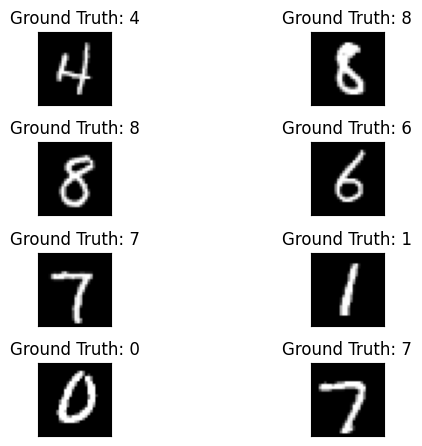

In [5]:
x, t = next(iter(loader['train']))

print(x.shape)

fig = plt.figure()
for i in range(8):
  plt.subplot(4,2,i+1)
  plt.tight_layout()
  plt.imshow(x[i,0,:,:], cmap='gray') #, interpolation='none')
  plt.title("Ground Truth: {}".format(t[i]))
  plt.xticks([])
  plt.yticks([])



Now, we will define a shallow CNN (two convolution layers).

**Exercise:**  Determine *N* in such a way that the network can accept MNIST images as input.

In [43]:
N = 490 #(7*7*10) size*size'*number of channels after the previous convolution
# YOUR CODE HERE
#raise NotImplementedError()

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding =2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, padding =2)
        self.fc1 = nn.Linear(N, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, N)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # Here, the log is applied after the softmax:
        return F.log_softmax(x, dim=1)

In [44]:
x = torch.tensor([[1,2,3],[4,5,6]])
x = x.view(-1,6)
x

tensor([[1, 2, 3, 4, 5, 6]])

In [45]:
model = CNN()

#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# We select the log likelihoods for the true classes:
loss_fn =  torch.nn.NLLLoss()

The training loop has two phases: weights are updated only in the first phase dedicated to training. During the validation phase, generalization performance on independent images is monitored:

In [48]:
import time

# Initialize time
start_time = time.time()

# Learning Loop:
for epoch in range(6):
    print(f'Epoch: {epoch}')

    running_loss_train = 0.0
    running_corrects_train = 0
    running_loss_val = 0.0
    running_corrects_val = 0

    # Phase 1: Training
    model.train()  # Set the model to training mode
    for x, label in loader['train']:
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Update counters:
        running_loss_train += loss.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    # Calculate training scores:
    epoch_loss_train = running_loss_train / dataset_sizes['train']
    epoch_acc_train = running_corrects_train.float() / dataset_sizes['train']

    print(f'Train Loss: {epoch_loss_train:.4f} Acc: {epoch_acc_train:.4f}')

    # Phase 2: Validation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for x, label in loader['val']:
            output = model(x)
            loss = loss_fn(output, label)

            # Get predicted classes:
            _, preds = torch.max(output, 1)

            # Update counters:
            running_loss_val += loss.item() * x.shape[0]
            running_corrects_val += torch.sum(preds == label.data)

    # Calculate validation scores and print:
    epoch_loss_val = running_loss_val / dataset_sizes['val']
    epoch_acc_val = running_corrects_val.float() / dataset_sizes['val']

    print(f'Validation Loss: {epoch_loss_val:.4f} Acc: {epoch_acc_val:.4f}')

    # Print elapsed time:
    elapsed_time = time.time() - start_time
    print(f'Time: {round(elapsed_time)} seconds')

    # Update start time for the next epoch
    start_time = time.time()

Epoch: 0
Train Loss: 0.0862 Acc: 0.9742
Validation Loss: 0.0491 Acc: 0.9876
Time: 71 seconds
Epoch: 1
Train Loss: 0.0818 Acc: 0.9750
Validation Loss: 0.0409 Acc: 0.9876
Time: 71 seconds
Epoch: 2
Train Loss: 0.0786 Acc: 0.9757
Validation Loss: 0.0411 Acc: 0.9874
Time: 73 seconds
Epoch: 3
Train Loss: 0.0777 Acc: 0.9769
Validation Loss: 0.0372 Acc: 0.9887
Time: 71 seconds
Epoch: 4
Train Loss: 0.0750 Acc: 0.9768
Validation Loss: 0.0350 Acc: 0.9909
Time: 73 seconds
Epoch: 5
Train Loss: 0.0747 Acc: 0.9779
Validation Loss: 0.0470 Acc: 0.9891
Time: 73 seconds


**Exercise**:
At each epoch, store the accuracy and the cost function value in the lists train_losses, val_losses, train_accs, and val_accs.
Plot the **learning curves** over six epochs. \\

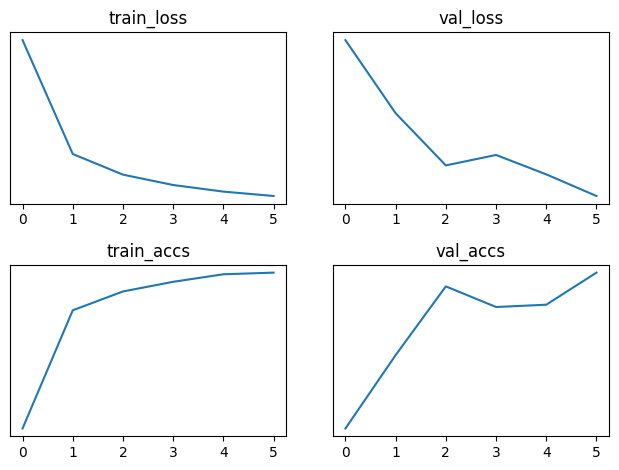

In [49]:
train_losses = [0.2890, 0.1406, 0.1137, 0.1002, 0.0916, 0.0859]
val_losses = [0.0598, 0.0500, 0.0430, 0.0444, 0.0418, 0.0389]

train_accs = [0.9083, 0.9585, 0.9665, 0.9706, 0.9738, 0.9745]
val_accs = [0.9816, 0.9848, 0.9878, 0.9869, 0.9870, 0.9884]
listofmetrics = [train_losses, val_losses, train_accs, val_accs]
names = ['train_loss', 'val_loss', 'train_accs', 'val_accs']
metrics_fig = plt.figure()

for i in range(4):
  plt.subplot(2,2,i+1)
  plt.tight_layout()
  plt.plot(listofmetrics[i]) #, interpolation='none')
  plt.title(names[i])
  #plt.xticks([])
  plt.yticks([])
# raise NotImplementedError()

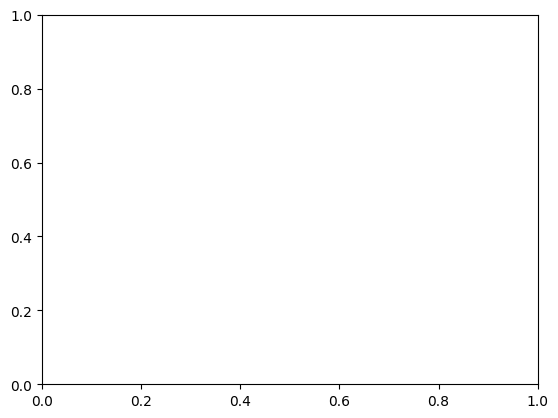

In [50]:
fig2, ax2 = plt.subplots()
# YOUR CODE HERE
# raise NotImplementedError()

**Exercise:** Take the two-layer perceptron (fc1 and fc2) from the TP1 part 2 and modify it to directly take MNIST images as input.
Compare the standalone perceptron to the CNN in terms of size (number of weights) and performance.

In [59]:
# YOUR CODE HERE
# raise NotImplementedError()



class P1(nn.Module):

    def __init__(self):
        super(P1, self).__init__()
        self.fc1 = nn.Linear(28*28, 60)
        self.fc2 = nn.Linear(60,10)

    def forward(self, x):
        x = x.view(-1,28*28)
        # Dot product and bias
        x = self.fc1(x)
        # Activation
        x = x.relu()
        x = self.fc2(x)
        x = x.relu()
        # Vector of "probabilities" (cat: concatenation)
        x = x.softmax(dim=1)
        return x

model2 = P1()
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.001)


In [60]:
# Comparaison des tailles:
total_parameters = sum(p.numel() for p in model.parameters())
print("Total parameters in the cnn model:", total_parameters)
# YOUR CODE
# raise NotImplementedError()

total_parameters = sum(p.numel() for p in model2.parameters())
print("Total parameters in the perceptron-like model:", total_parameters)

Total parameters in the cnn model: 27830
Total parameters in the perceptron-like model: 47710


In [61]:
# Performance comparison (on the validation set):
# YOUR CODE HERE
# raise NotImplementedError()

import time

# Initialize time
start_time = time.time()

# Learning Loop:
for epoch in range(6):
    print(f'Epoch: {epoch}')

    running_loss_train = 0.0
    running_corrects_train = 0
    running_loss_val = 0.0
    running_corrects_val = 0

    # Phase 1: Training
    model2.train()  # Set the model to training mode
    for x, label in loader['train']:
        optimizer.zero_grad()
        output = model2(x)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer2.step()

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Update counters:
        running_loss_train += loss.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    # Calculate training scores:
    epoch_loss_train = running_loss_train / dataset_sizes['train']
    epoch_acc_train = running_corrects_train.float() / dataset_sizes['train']

    print(f'Train Loss: {epoch_loss_train:.4f} Acc: {epoch_acc_train:.4f}')

    # Phase 2: Validation
    model2.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for x, label in loader['val']:
            output = model2(x)
            loss = loss_fn(output, label)

            # Get predicted classes:
            _, preds = torch.max(output, 1)

            # Update counters:
            running_loss_val += loss.item() * x.shape[0]
            running_corrects_val += torch.sum(preds == label.data)

    # Calculate validation scores and print:
    epoch_loss_val = running_loss_val / dataset_sizes['val']
    epoch_acc_val = running_corrects_val.float() / dataset_sizes['val']

    print(f'Validation Loss: {epoch_loss_val:.4f} Acc: {epoch_acc_val:.4f}')

    # Print elapsed time:
    elapsed_time = time.time() - start_time
    print(f'Time: {round(elapsed_time)} seconds')

    # Update start time for the next epoch
    start_time = time.time()

Epoch: 0
Train Loss: -0.1702 Acc: 0.1807
Validation Loss: -0.1509 Acc: 0.1547
Time: 40 seconds
Epoch: 1
Train Loss: -0.1464 Acc: 0.1504
Validation Loss: -0.1405 Acc: 0.1430
Time: 38 seconds
Epoch: 2
Train Loss: -0.1402 Acc: 0.1435
Validation Loss: -0.1368 Acc: 0.1389
Time: 40 seconds
Epoch: 3
Train Loss: -0.1376 Acc: 0.1406
Validation Loss: -0.1349 Acc: 0.1368
Time: 40 seconds
Epoch: 4
Train Loss: -0.1363 Acc: 0.1390
Validation Loss: -0.1335 Acc: 0.1352
Time: 40 seconds
Epoch: 5
Train Loss: -0.1354 Acc: 0.1381
Validation Loss: -0.1322 Acc: 0.1338
Time: 39 seconds


**Note:** It is not easy to improve scores with a larger perceptron:

In [ ]:
class BiggerPerceptron(nn.Module):

    def __init__(self):
        super(BiggerPerceptron, self).__init__()
        self.fc01 = nn.Linear(28*28, 50)
        self.fc02 = nn.Linear(50, 200)
        self.fc1 = nn.Linear(200, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc01(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc02(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
bigger_perceptron = BiggerPerceptron()
optimizer = torch.optim.Adam(bigger_perceptron.parameters(), lr = 0.001)
loss_fn =  torch.nn.NLLLoss()

In [ ]:
# bigger_perceptron :
nb_weights = 0
for module in bigger_perceptron.modules():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print(nb_weights)

In [ ]:
import time
t = time.time()

train_losses_p = []
val_losses_p = []

train_accs_p= []
val_accs_p = []

loader ={x :  DataLoader(ds[x], batch_size=bs, shuffle=True, num_workers = 4) for x in phases}

#training loop:
for epoch in range(15):
    print('epoch :' + str(epoch))

    running_loss_train = 0.
    running_corrects_train = 0.
    running_loss_val = 0.
    running_corrects_val = 0.

    for x, label in loader['train']:
        optimizer.zero_grad()
        output = bigger_perceptron(x)
        l = loss_fn(output, label)
        l.backward()
        optimizer.step()

        _, preds = torch.max(output, 1)
        running_loss_train += l.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    epoch_loss_train = running_loss_train / dataset_sizes['train']
    epoch_acc_train = running_corrects_train.float() / dataset_sizes['train']

    train_losses_p.append(epoch_loss_train)
    train_accs_p.append(epoch_acc_train)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'train', epoch_loss_train, epoch_acc_train))

    bigger_perceptron.eval()

    for x, label in loader['val']:

        with torch.no_grad():
            output = bigger_perceptron(x)
            l = loss_fn(output, label)

        _, preds = torch.max(output, 1)
        running_loss_val += l.item() * x.shape[0]
        running_corrects_val += torch.sum(preds == label.data)

    epoch_loss_val = running_loss_val / dataset_sizes['val']
    epoch_acc_val = running_corrects_val.float() / dataset_sizes['val']

    val_losses_p.append(epoch_loss_val)
    val_accs_p.append(epoch_acc_val)


    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'val', epoch_loss_val, epoch_acc_val))

    new_t = time.time()
    print('time ' +str(round(new_t- t)))
    t = new_t
